# ISYE 6740, Spring 2021, Homework 3
## Katherine Barthelson

## Part 1. Order of faces using ISOMAP [50 points]
This question aims to reproduce the ISOMAP algorithm results in the original paper for ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323 that we have also seen in the lecture as an exercise (isn’t this exciting to go through the process of generating results for a high-impact research paper!)

The file isomap.mat (or isomap.dat) contains 698 images, corresponding to different poses of the same face. Each image is given as a 64 × 64 luminosity map, hence represented as a vector in R4096. This vector is stored as a row in the file. [This is one of the datasets used in the original paper] In this question, you are expected to implement the ISOMAP algorithm by coding it up yourself. You may use the provided functions in ShortestPath.zip to find the shortest path as required by one step of the algorithm. To load data in Python, for instance, you can use from scipy.io import loadmat, images = loadmat(‘isomap.mat’)[‘images’]. To load data in Matlab, you can directly use load() function.
Choose the Euclidean distance (i.e., in this case, a distance in R4096) to construct the nearest neighbor graph—vertices corresponding to the images. Construct a similarity graph with vertices corresponding to the images, and tune the threshold ε so that each node has at least K = 50 neighbors (this approach corresponds to the so-called ε-Isomap).

In [1]:
# Import libraries and load data
import pandas as pd
import numpy as np
import networkx
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from scipy.io import loadmat
import glob

images = loadmat("data/isomap.mat")['images']
images = pd.DataFrame(images).T
display(images)
display(images.shape)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016176,0.016176,0.016176,0.016176,0.016988,0.028140,0.047518,0.050950,0.080469,0.116146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.016176,0.016176,0.016176,0.024188,0.039859,0.040671,0.038710,0.035983,0.034559,0.033517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.031388,0.130867,0.274341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(698, 4096)

Define Shortest path function provided in the data folder:

In [2]:
import numpy as np
import networkx as nx

# Code provided in homework folder
def Matrix_D(W):
    # Generate Graph and Obtain Matrix D, 
    # from weight matrix W defining the weight on the edge between each pair of nodes.
    # Note that you can assign sufficiently large weights to non-existing edges.

    n = np.shape(W)[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(W[i,j], W[j,i]))])

    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    np.savetxt('D.csv', D)
    return D

(a) (10 points) Visualize the similarity graph (you can either show the adjacency matrix, or similar to the lecture slides, visualize the graph using graph visualization packages such as Gephi (https://gephi.org) and illustrate a few images corresponds to nodes at different parts of the graph, e.g., mark them by hand or use software packages).

In [3]:
from scipy.spatial.distance import cdist
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.utils.graph import graph_shortest_path
# build weighted graph A using nearest neighbors
# compute pairwise shortest distance matrix D
# use a centering matrix H to get C
# compute leading eigenvectors and eigenvalues of C

# Based on steps in demo code. 
# Made a function to call for both euclidean and manhattan distance

def isomap(im, k_neighbors, dist):
    m,n = im.shape # 4096 x 698
    
    # Compute the pairwise distance matrix
    distances = cdist(im,im,dist)
    
    # Build weighted graph A using nearest neighbors
    A = np.zeros(distances.shape)
    
    # Loop through distances, assign distance as the weight into the adj matrix
    for i in range(A.shape[0]):
        neighbors = np.argsort(distances[i,:])[:k_neighbors+1] # force 50 neighbors 
        A[i,neighbors] = distances[i,neighbors]
    
    # Compute A as a binary matrix
    A = np.where(A > 0, 1, 0)
    
    # compute pairwise shortest distance matrix D from weighted graph A
    #D = Matrix_D(A)
    D = graph_shortest_path(A)
    # display(D.shape) # 
    
    # Use a centering matrix H to get C
    I = np.eye(D.shape[1])
    H = I - (1/m)*np.transpose(11)
    C = (-1/2)*(H**2)*(D**2)
    
    # compute leading eigenvectors and eigenvalues of C - from last HW
    vals, vecs = np.linalg.eigh(C)
    sorted_vals = vals[np.argsort(-vals)]
    sorted_vecs = vecs[:,np.argsort(-vals)]
    
    # Normalize the eigenvectors for reconstructed map that preserves distances
    Z = sorted_vecs[:,:2]*(sorted_vals[:2])**(1/2)
    
    return A,Z

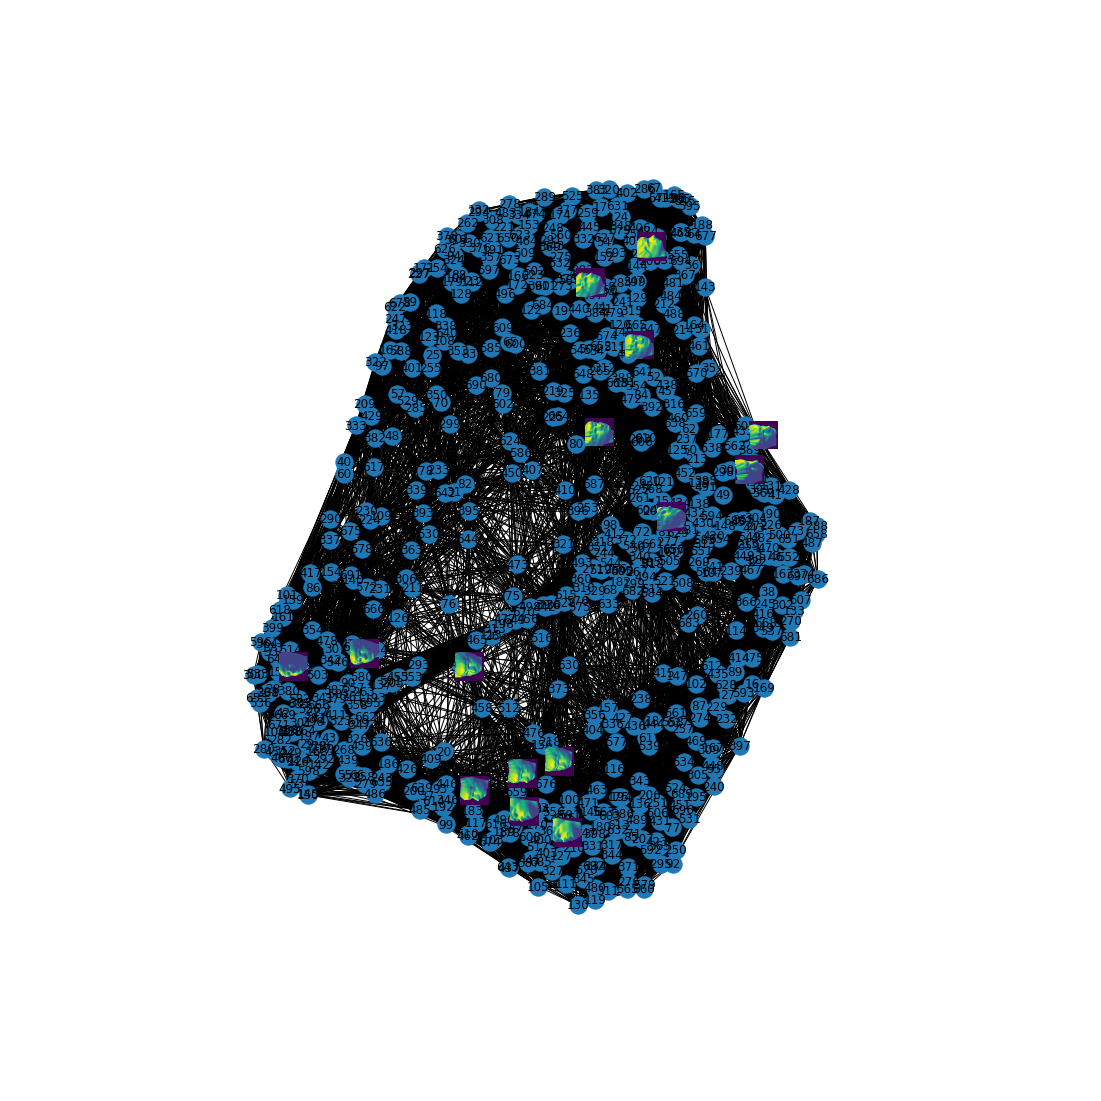

In [4]:
# Apply isomap for 50 neighbors
import math
nodes = 50
A, Z = isomap(images,nodes,"Euclidean")
# Plot adjacency matrix with the graph tool (networkx)
G = nx.from_numpy_matrix(A)

# Build 6 images to add as nodes
# adapted from: https://stackoverflow.com/questions/53967392/creating-a-graph-with-images-as-nodes
num_images, num_pixels = images.shape
pixels_per_dimension = int(math.sqrt(num_pixels))

k=15
for num in range(k):
    img = images.iloc[num,:].values.reshape(pixels_per_dimension, pixels_per_dimension)
    G.add_node(num,image= img)
    G.add_edge(0,num)

pos = nx.spring_layout(G)

fig=plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx(G,pos,ax=ax)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.02 # this is the image size
p2=piesize/2.0
i = 0 # force stop after k images shown
for n in G:
    if i < k:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.axis('off')
        i+=1
    else:
        break
ax.axis('off')
plt.show()

(b) (20 points) Implement the ISOMAP algorithm yourself to obtain a two-dimensional low-dimensional embedding. Plot the embeddings using a scatter plot, similar to the plots in lecture slides. Find a few images in the embedding space and show what these images look like. Comment on do you see any visual similarity among them and their arrangement, similar to what you seen in the paper?

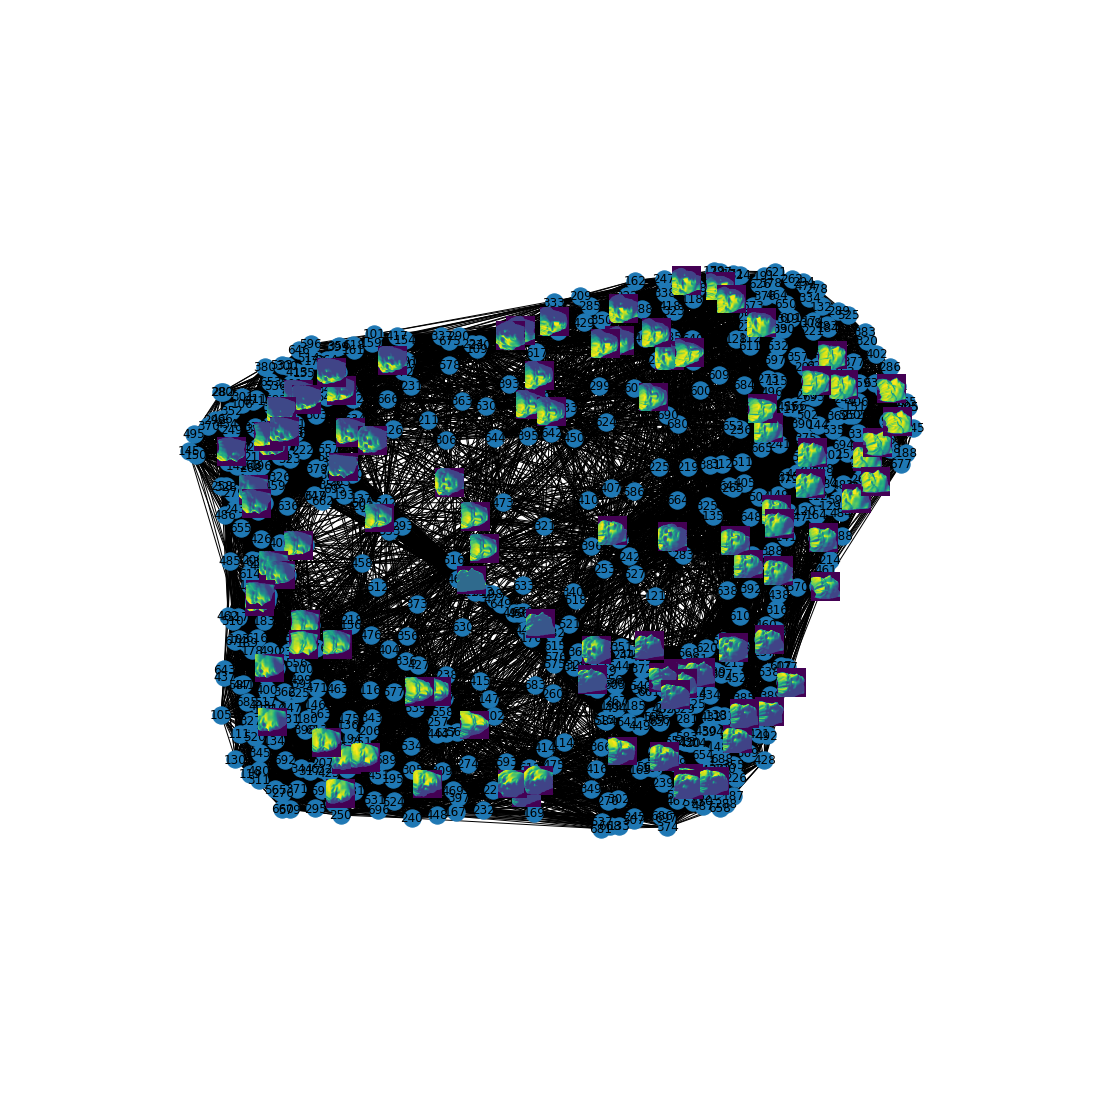

In [5]:
# Plot embeddings
Gplot = A#Z*Z.T
G2 = nx.from_numpy_matrix(Gplot)
#plt.scatter(Z[0],Z[1], marker='o')

# Build k images to add as nodes
k=100
# adapted from: https://stackoverflow.com/questions/53967392/creating-a-graph-with-images-as-nodes
num_images, num_pixels = images.shape
pixels_per_dimension = int(math.sqrt(num_pixels))
for num in range(k):
    img = images.iloc[num,:].values.reshape(pixels_per_dimension, pixels_per_dimension)
    G2.add_node(num,image= img)
    G2.add_edge(0,num)

pos = nx.spring_layout(G2)

fig=plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx(G2,pos,ax=ax)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.02 # this is the image size
p2=piesize/2.0
i = 0 # force stop after k images shown
for n in G2:
    if i < k:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G2.nodes[n]['image'])
        a.axis('off')
        i+=1
    else:
        break
ax.axis('off')
plt.show()

In this graph, faces are looking in a similar direction. Compared to the paper, it looks like the faces are facing the opposite direction (inward instead of outward). This causes the faces in the middle to look more different from each other as there is a big change when faces are essentially looking at each other in the graph.

(c) (10 points) Now choose l1 distance (or Manhattan distance) between images (recall the definition from “Clustering” lecture)). Repeat the steps above. Use ε-ISOMAP to obtain a k = 2 dimensional embedding. Present a plot of this embedding. Do you see
1 any difference by choosing a different similarity measure by comparing results in Part (b) and Part (c)?


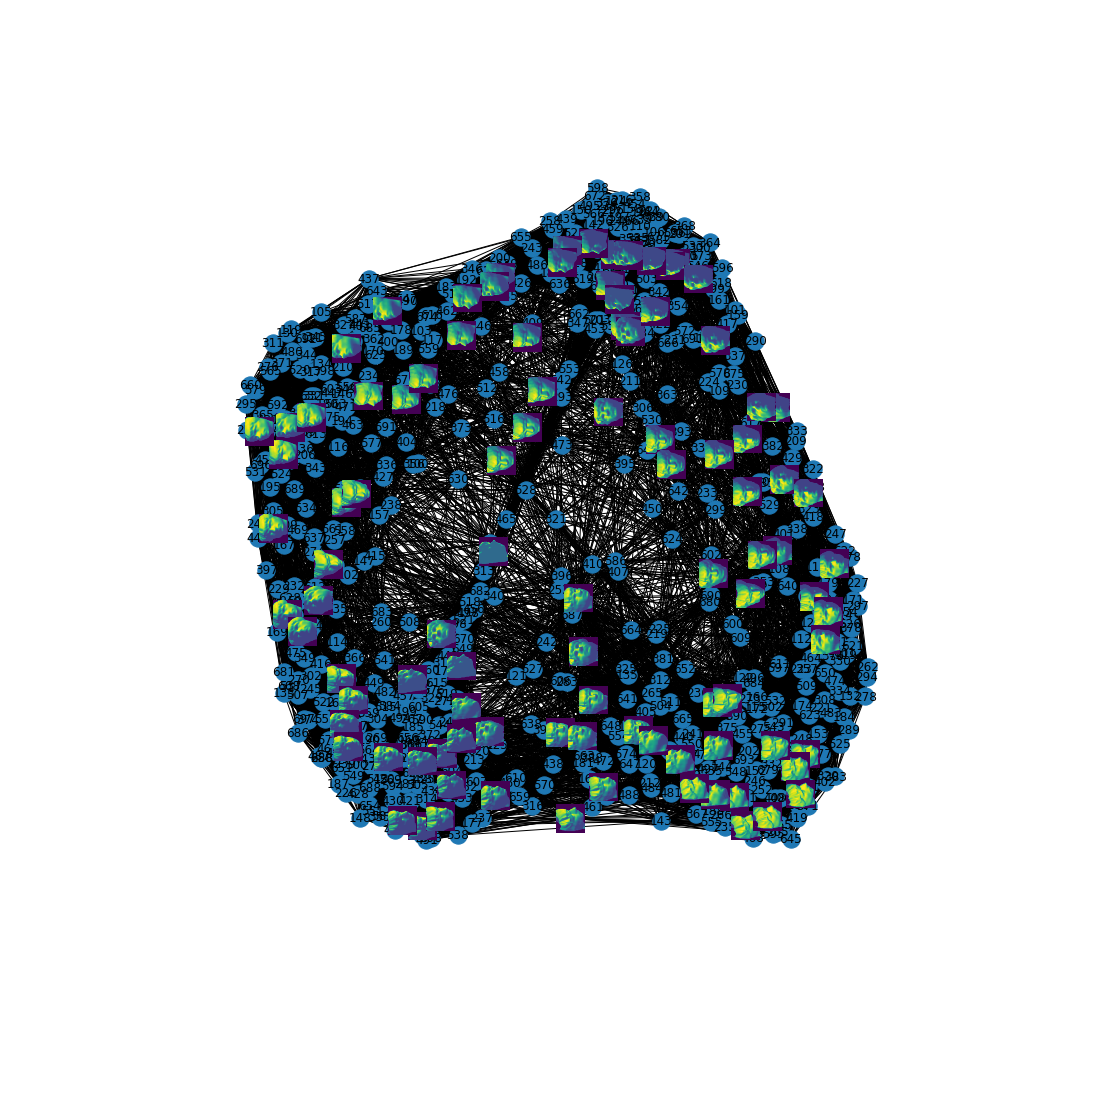

In [6]:
A2, Z2 = isomap(images,nodes,'cityblock') # 'cityblock' = Manhattan
# Plot adjacency matrix with the graph tool (networkx)
G3 = nx.from_numpy_matrix(A2)

# Build k images to add as nodes
k=100
# adapted from: https://stackoverflow.com/questions/53967392/creating-a-graph-with-images-as-nodes
num_images, num_pixels = images.shape
pixels_per_dimension = int(math.sqrt(num_pixels))
for num in range(k):
    img = images.iloc[num,:].values.reshape(pixels_per_dimension, pixels_per_dimension)
    G3.add_node(num,image= img)
    G3.add_edge(0,num)

pos = nx.spring_layout(G3)

fig=plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx(G3,pos,ax=ax)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.02 # this is the image size
p2=piesize/2.0
i = 0 # force stop after k images shown
for n in G3:
    if i < k:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G3.nodes[n]['image'])
        a.axis('off')
        i+=1
    else:
        break
ax.axis('off')
plt.show()

The graph above shows faces close to each other that are looking in a similar direction, the same in part b. However, part b shows faces facing inward instead of outward as shown in part c. This graph looks more similar to the graph in the paper.

(d) (10 points) Perform PCA (you can now use your implementation written in Question 1) on the images and project them into the top 2 principal components. Again show them on a scatter plot. Explain whether or you see a more meaningful projection using ISOMAP than PCA.

Although I could not get code to work for this question, my understanding from the paper is that a more meaningful projection can be achieved using ISOMAP as PCA fails to detect nonlinear structures. The primary reason is that ISOMAP can achieve greater dimensionality reduction while using more meaningful features to obtain optimally low dimensions. The primary reason is that ISOMAP uses manifolds to identify shortest distance through the use of nonlinear geometry.

## Part 2. Density estimation: Psychological experiments. (50 points)
We will use this data to study whether or not the two brain regions are likely to be indepen- dent of each other and considering different types of political view For this question; you can use the proper package for histogram and KDE; no need to write your own. The data set n90pol.csv contains information on 90 university students who participated in a psychological experiment designed to look for relationships between the size of different regions of the brain and political views. The variables amygdala and acc indicate the volume of two particular brain regions known to be involved in emotions and decision-making, the amygdala and the anterior cingulate cortex; more exactly, these are residuals from the pre- dicted volume, after adjusting for height, sex, and similar body-type variables. The variable orientation gives the students’ locations on a five-point scale from 1 (very conservative) to 5 (very liberal). Note that in the dataset, we only have observations for orientation from 2 to 5.
Recall in this case, the kernel density estimator (KDE) for a density is given by
we discussed in lecture. For one-dimensional KDE, use a one-dimensional Gaussian kernel K(x)=√1 e−x2/2.
2π
For two-dimensional KDE, use a two-dimensional Gaussian kernel: for
􏰂x1􏰃 2 x=x∈R,
2
where x1 and x2 are the two dimensions respectively
1 − (x1)2+(x2)2 K(x)= e 2 .
2π

In [7]:
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
import scipy.sparse.linalg as ll
from sklearn.neighbors import KernelDensity
import seaborn as sns

n90pol = pd.read_csv('data/n90pol.csv') #.to_numpy()
display(n90pol.head(5))

,amygdala,acc,orientation
0,0.0051,-0.0286,2
1,-0.0674,0.0007,3
2,-0.0257,-0.0110,3
3,0.0504,-0.0167,2
4,0.0125,-0.0005,5


In [8]:
# From the demo code method of preprocessing
ndata = preprocessing.scale(n90pol)
m, n = ndata.shape
C = np.matmul(ndata.T, ndata)/m
# pca the data
d = 2
S,V = np.linalg.eigh(C)
# project the data to the top 2 princ. directions
pdata = np.dot(ndata,-V.real)

(a) (10 points) Form the 1-dimensional histogram and KDE to estimate the distributions of amygdala and acc, respectively. For this question, you can ignore the variable orientation. Decide on a suitable number of bins so you can see the shape of the distribution where xi are two-dimensional vectors, h > 0 is the kernel bandwidth, based on the criterion
  
clearly. Set an appropriate kernel bandwidth h > 0. For example. for one-dimensional KDE, you are welcome to use a rule-of-thumb bandwidth estimator
h ≈ 1.06σˆn−1/5,
where n is the sample size, σˆ is the standard error of samples; this is shown to be
optimal when Gaussian kernel functions are used for univariate data.

Both acc and amygdala have optimal bins equal to 10.

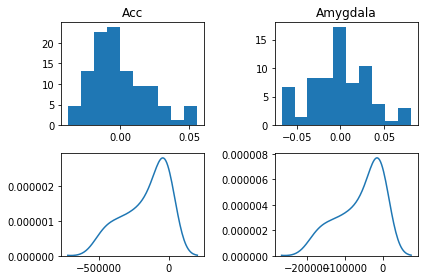

In [9]:
from sklearn.neighbors import KernelDensity

# create the data sets for amygdala and acc
acc = n90pol['acc']
amygdala = n90pol['amygdala']

# create KDE model
sigacc = acc.sem() # std error
sigamy = amygdala.sem() # std error
n=len(acc) # n is the sample size, same for both
bandacc = 1.06*sigacc*n**(-1/5) 
bandamy = 1.06*sigamy*n**(-1/5)
kde_acc = KernelDensity(bandwidth=bandacc, kernel='gaussian')
kde_acc.fit(acc[:, None])
kde_amygdala = KernelDensity(bandwidth=bandamy, kernel='gaussian')
kde_amygdala.fit(amygdala[:, None])

# create test data
test = np.linspace(0,1,90)
test = test.reshape(acc.shape).reshape(-1, 1)

# score_samples returns the log of the probability density
logprob_acc = kde_acc.score_samples(test)
logprob_amygdala = kde_amygdala.score_samples(test)

# plot the histograms and KDEs
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.hist(acc, density=True) # autogenerate bins = 10
ax0.set_title('Acc')
ax1.hist(amygdala, density=True) # autogenerate bins = 10
ax1.set_title('Amygdala')

sns.kdeplot(ax=ax2,data=logprob_acc)
sns.kdeplot(ax=ax3,data=logprob_amygdala)

plt.tight_layout()

(b) (10 points) Form 2-dimensional histogram for the pairs of variables (amygdala, acc). Decide on a suitable number of bins so you can see the shape of the distribution clearly.

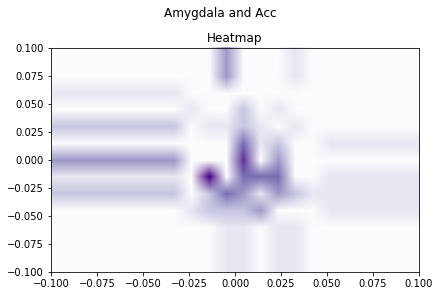

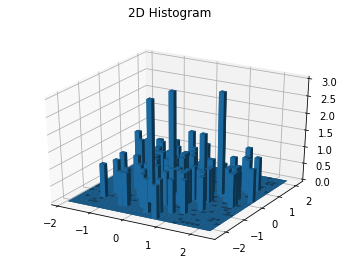

In [10]:
from numpy import histogram2d
from matplotlib.image import NonUniformImage
from matplotlib import cm

# create the data sets for amygdala and acc
dim2 = n90pol[['acc','amygdala']]

# plot the histograms - 
# this heatmap is not correct but I attempted multiple methods from demo code
H, xedges, yedges = np.histogram2d(x=dim2['acc'],y=dim2['amygdala'], density=True) # autogenerate bins = 10

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle('Amygdala and Acc', fontsize='large')
im = NonUniformImage(ax, interpolation='bilinear', extent=(-.1, .1, -.1, .1),
                     cmap=cm.Purples)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, H)
ax.images.append(im)
ax.set_xlim(-.1, .1)
ax.set_ylim(-.1, .1)
ax.set_title('Heatmap')
plt.show()

# for 2 dimensional data - from demo code
min_data = pdata.min(0)
max_data = pdata.max(0)
nbin = 30
fig = plt.figure()
fig.suptitle('2D Histogram', fontsize='large')
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(pdata[:,0], pdata[:,1], bins=nbin)
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])
xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)
dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz )

(c) (10 points) Use kernel-density-estimation (KDE) to estimate the 2-dimensional density function of (amygdala, acc) (this means for this question, you can ignore the variable orientation). Set an appropriate kernel bandwidth h > 0.
Please show the two-dimensional KDE (e.g., two-dimensional heat-map, two-dimensional contour plot, etc.)
Please explain based on the results, can you infer that the two variables (amygdala, acc) are likely to be independent or not?

/Users/KatieBarthelson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


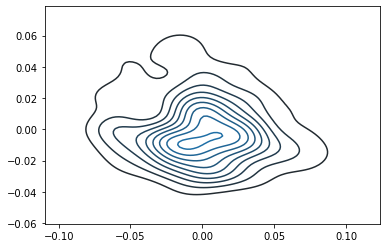

In [12]:
from sklearn.neighbors import KernelDensity

# create the data sets for amygdala and acc
dimdens = np.append(n90pol['acc'],n90pol['amygdala'])
x = n90pol['acc']
y = n90pol['amygdala']

# create grid of samples - from demo code + piazza
xx, yy = np.mgrid[x.min():x.max():90j, y.min():y.max():90j]

xy_train  = np.vstack([y, x]).T
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

kde = KernelDensity(kernel='gaussian') # default optimal bandwidth
kde.fit(xy_train)
z = np.exp(kde.score_samples(xy_sample))

# Contour plot
sns.kdeplot(xy_train) # x="acc",y="amygdala"
plt.show()

### ANS
If Px*Py = Pxy, the responses are independent. The 2 dimensional KDE shows the joint distribution, so based on the chart above, amygdala and acc are likely independent.

(d) (10 points) We will consider the variable orientation and consider conditional distri- butions. Please plot the estimated conditional distribution of amygdala conditioning on political orientation: p(amygdala|orientation = c), c = 2, . . . , 5, using KDE. Set an appropriate kernel bandwidth h > 0. Do the same for the volume of the acc: plot p(acc|orientation = c), c = 2, . . . , 5 using KDE. (Note that the conditional distribution can be understood as fitting a distribution for the data with the same orientation. Thus you should plot 8 one-dimensional distribution functions in total for this question.)
Now please explain based on the results, can you infer that the conditional distribution of amygdala and acc, respectively, are different from c = 2,...,5? This is a type of scientific question one could infer from the data: Whether or not there is a difference between brain structure and political view.
Now please also fill out the conditional sample mean for the two variables: c=2 c=3 c=4 c=5
amygdala acc
Remark: As you can see this exercise, you can extract so much more information from density estimation than simple summary statistics (e.g., the sample mean) in terms of explorable data analysis.

Mean of Acc when c=2: %d -0.014769230769230767
Mean of Acc when c=3: %d 0.0016708333333333338
Mean of Acc when c=4: %d 0.001309756097560975
Mean of Acc when c=5: %d 0.008141666666666667

Mean of Amygdala when c=2: %d 0.01906153846153846
Mean of Amygdala when c=3: %d 0.0005875000000000013
Mean of Amygdala when c=4: %d -0.004719512195121951
Mean of Amygdala when c=5: %d -0.005691666666666667


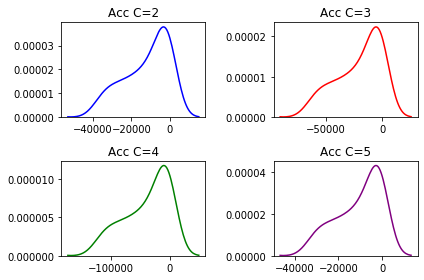

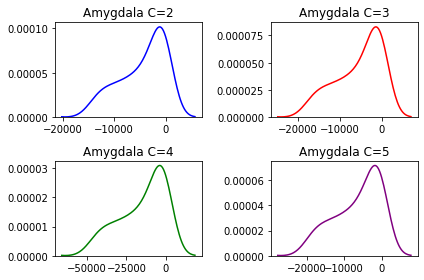

In [13]:
# same as part c but filter by each orientation
# group by not from kde. mean of the samples for each (acc, etc) where c=2, etc

# filter the data
c2 = n90pol[n90pol['orientation']==2]
c3 = n90pol[n90pol['orientation']==3]
c4 = n90pol[n90pol['orientation']==4]
c5 = n90pol[n90pol['orientation']==5]

c2amy = c2['amygdala']
c3amy = c3['amygdala']
c4amy = c4['amygdala']
c5amy = c5['amygdala']
c2acc = c2['acc']
c3acc = c3['acc']
c4acc = c4['acc']
c5acc = c5['acc']

# create KDE model - acc for each orientation
print("Mean of Acc when c=2: %d", np.mean(c2acc))
print("Mean of Acc when c=3: %d", np.mean(c3acc))
print("Mean of Acc when c=4: %d", np.mean(c4acc))
print("Mean of Acc when c=5: %d", np.mean(c5acc))
n=len(c2acc) # n is the sample size, same for all
# c=2
sigacc2 = c2acc.sem() # std error
bandacc2 = 1.06*sigacc2*n**(-1/5) 
kde_acc2 = KernelDensity(bandwidth=bandacc2, kernel='gaussian')
kde_acc2.fit(c2acc[:, None])
# c=3
sigacc3 = c3acc.sem() # std error
bandacc3 = 1.06*sigacc3*n**(-1/5) 
kde_acc3 = KernelDensity(bandwidth=bandacc3, kernel='gaussian')
kde_acc3.fit(c3acc[:, None])
# c=4
sigacc4 = c4acc.sem() # std error
bandacc4 = 1.06*sigacc4*n**(-1/5) 
kde_acc4 = KernelDensity(bandwidth=bandacc4, kernel='gaussian')
kde_acc4.fit(c4acc[:, None])
# c=5
sigacc5 = c5acc.sem() # std error
bandacc5 = 1.06*sigacc5*n**(-1/5) 
kde_acc5 = KernelDensity(bandwidth=bandacc5, kernel='gaussian')
kde_acc5.fit(c5acc[:, None])

# create test data
test = np.linspace(0,1,90)
test = test.reshape(acc.shape).reshape(-1, 1)

# return the log of the probability density for each kde
logprob_acc2 = kde_acc2.score_samples(test)
logprob_acc3 = kde_acc3.score_samples(test)
logprob_acc4 = kde_acc4.score_samples(test)
logprob_acc5 = kde_acc5.score_samples(test)

# plot the histograms and KDEs for each orientation
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
sns.kdeplot(ax=ax0,data=logprob_acc2,color='blue').set_title('Acc C=2')
sns.kdeplot(ax=ax1,data=logprob_acc3,color='red').set_title('Acc C=3')
sns.kdeplot(ax=ax2,data=logprob_acc4,color='green').set_title('Acc C=4')
sns.kdeplot(ax=ax3,data=logprob_acc5,color='purple').set_title('Acc C=5')
plt.tight_layout()

# create KDE model - amygdala for each orientation
print("\nMean of Amygdala when c=2: %d", np.mean(c2amy))
print("Mean of Amygdala when c=3: %d", np.mean(c3amy))
print("Mean of Amygdala when c=4: %d", np.mean(c4amy))
print("Mean of Amygdala when c=5: %d", np.mean(c5amy))
n=len(c2amy) # n is the sample size, same for all
# c=2
sigamy2 = c2amy.sem() # std error
bandamy2 = 1.06*sigamy2*n**(-1/5) 
kde_amy2 = KernelDensity(bandwidth=bandamy2, kernel='gaussian')
kde_amy2.fit(c2amy[:, None])
# c=3
sigamy3 = c3amy.sem() # std error
bandamy3 = 1.06*sigamy3*n**(-1/5) 
kde_amy3 = KernelDensity(bandwidth=bandamy3, kernel='gaussian')
kde_amy3.fit(c3amy[:, None])
# c=4
sigamy4 = c4amy.sem() # std error
bandamy4 = 1.06*sigamy4*n**(-1/5) 
kde_amy4 = KernelDensity(bandwidth=bandamy4, kernel='gaussian')
kde_amy4.fit(c4amy[:, None])
# c=5
sigamy5 = c5amy.sem() # std error
bandamy5 = 1.06*sigamy5*n**(-1/5) 
kde_amy5 = KernelDensity(bandwidth=bandamy5, kernel='gaussian')
kde_amy5.fit(c5amy[:, None])

# create test data
test = np.linspace(0,1,90)
test = test.reshape(amygdala.shape).reshape(-1, 1)

# return the log of the probability density for each kde
logprob_amy2 = kde_amy2.score_samples(test)
logprob_amy3 = kde_amy3.score_samples(test)
logprob_amy4 = kde_amy4.score_samples(test)
logprob_amy5 = kde_amy5.score_samples(test)

# plot the histograms and KDEs for each orientation
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
sns.kdeplot(ax=ax0,data=logprob_amy2,color='blue').set_title('Amygdala C=2')
sns.kdeplot(ax=ax1,data=logprob_amy3,color='red').set_title('Amygdala C=3')
sns.kdeplot(ax=ax2,data=logprob_amy4,color='green').set_title('Amygdala C=4')
sns.kdeplot(ax=ax3,data=logprob_amy5,color='purple').set_title('Amygdala C=5')
plt.tight_layout()

### ANS
Although the shapes of the plots look similar and the mean of the distributions shift vary slightly to the left or right, the tails of the KDE plots very significantly. The main difference in the KDEs can be seen in the left extremes. It is interesting to note that for both Acc and Amygdala, the most extreme political orientations (c=2 and c=5) show very similar distributions. One could infer that the brain does vary based on political orientation, but these plots show more attribution to whether the person holds a more extreme view or a more moderate view rather than whether they lean more conservative or more liberal. There are no real similarities between the variables Acc and Amygdala

In this exercise, the summary statistic (mean) is not as useful.

(e) (10 points) Again we will consider the variable orientation. We will estimate the conditional joint distribution of the volume of the amygdala and acc, conditioning on a function of political orientation: p(amygdala, acc|orientation = c), c = 2, . . . , 5. You
3
    
will use two-dimensional KDE to achieve the goal; et an appropriate kernel band- width h > 0. Please show the two-dimensional KDE (e.g., two-dimensional heat-map, two-dimensional contour plot, etc.).
Please explain based on the results, can you infer that the conditional distribution of two variables (amygdala, acc) are different from c = 2, . . . , 5? This is a type of scientific question one could infer from the data: Whether or not there is a difference between brain structure and political view.
4

/Users/KatieBarthelson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/Users/KatieBarthelson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/Users/KatieBarthelson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/Users/KatieBarthelson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:693:

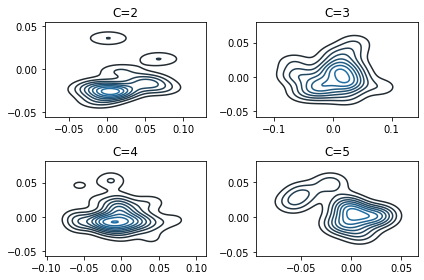

In [14]:
# test indep. between x and y for all orientatons
# same independence test as c. independence - x*y = ?
# repeat independence test only on c=2 .. 5 and then repeat d
# pdf = integrated over whole space = 1 - integrate cdf

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

# create the data sets for amygdala and acc where c=2 --------
x = c2['acc']
y = c2['amygdala']

# create grid of samples - from demo code + piazza
xx, yy = np.mgrid[x.min():x.max():90j, y.min():y.max():90j]

xy_train  = np.vstack([y, x]).T
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

kde = KernelDensity(kernel='gaussian')
kde.fit(xy_train)
z = np.exp(kde.score_samples(xy_sample))

# Contour plot
sns.kdeplot(xy_train,ax=ax0) # x="acc",y="amygdala"
ax0.set_title('C=2')

# create the data sets for amygdala and acc where c=2 --------
x = c3['acc']
y = c3['amygdala']

# create grid of samples - from demo code + piazza
xx, yy = np.mgrid[x.min():x.max():90j, y.min():y.max():90j]

xy_train  = np.vstack([y, x]).T
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

kde = KernelDensity(kernel='gaussian')
kde.fit(xy_train)
z = np.exp(kde.score_samples(xy_sample))

# Contour plot
sns.kdeplot(xy_train,ax=ax1) # x="acc",y="amygdala"
ax1.set_title('C=3')

# create the data sets for amygdala and acc where c=2 --------
x = c4['acc']
y = c4['amygdala']

# create grid of samples - from demo code + piazza
xx, yy = np.mgrid[x.min():x.max():90j, y.min():y.max():90j]

xy_train  = np.vstack([y, x]).T
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

kde = KernelDensity(kernel='gaussian')
kde.fit(xy_train)
z = np.exp(kde.score_samples(xy_sample))

# Contour plot
sns.kdeplot(xy_train,ax=ax2) # x="acc",y="amygdala"
ax2.set_title('C=4')

# create the data sets for amygdala and acc where c=2 --------
x = c5['acc']
y = c5['amygdala']

# create grid of samples - from demo code + piazza
xx, yy = np.mgrid[x.min():x.max():90j, y.min():y.max():90j]

xy_train  = np.vstack([y, x]).T
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

kde = KernelDensity(kernel='gaussian')
kde.fit(xy_train)
z = np.exp(kde.score_samples(xy_sample))

# Contour plot
sns.kdeplot(xy_train,ax=ax3) # x="acc",y="amygdala"
ax3.set_title('C=5')

plt.tight_layout()

### ANS
Based on the conditional conditional distribution and the previous KDE distributions, the primary differences are shown in the orientation more than the two variables (amygdala, acc).

Again, there is more similarity between whether a person is more moderate or more extreme than whether a person leans more conservative or more liberal (based on range and shape). However, I would not consider this to be enough to say there is a difference between brain structure and political view.